## SPOT: Silly Parsing for Optical Texts

In [5]:
import pandas as pd
import numpy as np
import cv2
import pytesseract
custom_config = r' - oem 3 - psm 6'
from matplotlib import pyplot as plt
# pytesseract.pytesseract.tesseract_cmd = 'C:\Program Files\Tesseract-OCR\tesseract.exe'
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

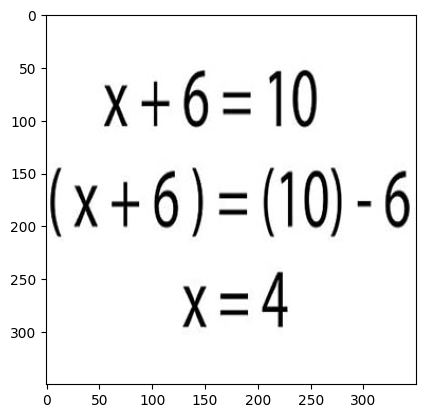

In [6]:
# load raw image
# img = cv2.imread("akqcT.PNG",0)
img = cv2.imread("simple-eq.jpg",0)
# display raw image
plt.imshow(img, cmap="gray")
plt.show()

In [7]:
def sharpen_image(im):
    # Define the sharpening kernel
    kernel = np.array([[0, -1, 0],
                       [-1,  9, -1],
                       [0, -1, 0]])

    # Apply the kernel to the image using convolution
    sharpened = cv2.filter2D(im, -1, kernel)

    return sharpened
# def sharpen_image(im):
#   kernel = np.ones((3,3),np.float32)/90
#   im = cv2.filter2D(im,-1,kernel)
#   return im

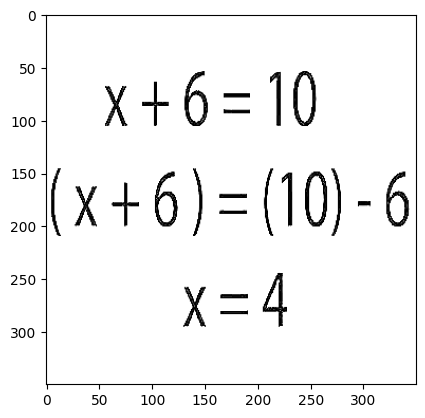

In [8]:
# img = cv2.equalizeHist(img)
img = sharpen_image(img)
# display sharpened image
plt.imshow(img, cmap="gray")
plt.show()

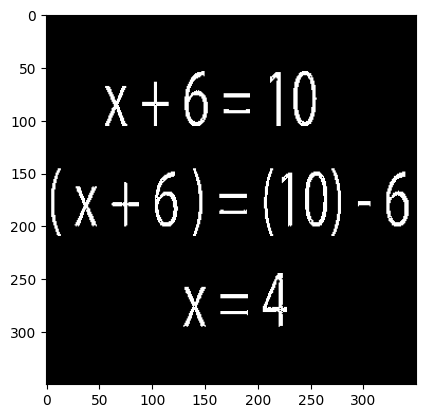

In [9]:
# # apply image thresholding
# img_blur = cv2.GaussianBlur(img, (5, 5), 0)
# img_thresh = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
# # invert the image, 255 is the maximum value
# img_thresh = 255 - img_thresh

# # Apply Gaussian blur to reduce noise
# # img_blur = cv2.GaussianBlur(img, (5, 5), 0)

# # # Apply adaptive thresholding using Gaussian method
# # img_thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

# # # Invert the binary image (255 is the maximum value)
# # img_thresh = 255 - img_thresh
# # display image
# plt.imshow(img_thresh)
# plt.show()
# apply image thresholding

# possibly use canny edge detection to filter the image so it can be usable. this involves a some additional machine learning to see how much blurring and artifact removing is required. Pretty complex stuff. Lets keep it simple for now. get an MVP then we do Heijunka and improve. 
blurred_img = img
# for i in range(3):
    # blurred_img = cv2.GaussianBlur(blurred_img, (3, 3), 0)
    # blurred_img = cv2.GaussianBlur(blurred_img, (3, 3), 0)
    # blurred_img = cv2.GaussianBlur(blurred_img, (3, ), 0)
# img = blurred_img

img_thresh = cv2.adaptiveThreshold(blurred_img,    
          255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,4)
# invert the image, 255 is the maximum value
img_thresh = 255 - img_thresh
# img_thresh = cv2.equalizeHist(img_thresh)
# display image
plt.imshow(img_thresh, cmap="gray")
plt.show()

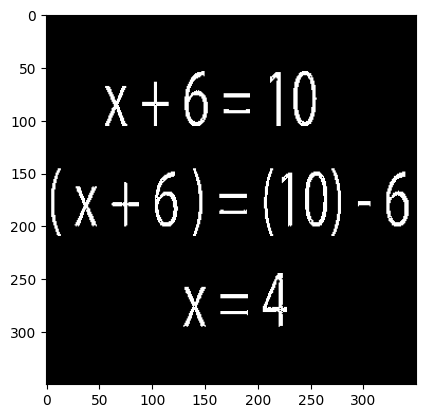

In [10]:
def align_text(im):
    # Binarize the image
    _, img_thresh = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Get image dimensions
    h, w = im.shape
    
    # Find coordinates of non-zero elements
    coords = np.column_stack(np.where(img_thresh > 0))
    
    # Calculate rotation angle
    angle = cv2.minAreaRect(coords)[-1]
    
    # Check if the angle is already close to 90 degrees within a tolerance
    if abs(angle - 90) < 5:  # Adjust the tolerance as needed
        return im  # Return the original image without rotation
    
    # Otherwise, adjust angle to rotate text to 90 degrees
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    
    # Define rotation center
    center = (w // 2, h // 2)
    
    # Compute rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Apply rotation to the original image
    rotated = cv2.warpAffine(im, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

# Align text within the image to be level (rotated to 90 degrees)
img_thresh = align_text(img_thresh)

# Display the aligned image
plt.imshow(img_thresh, cmap="gray")
plt.show()


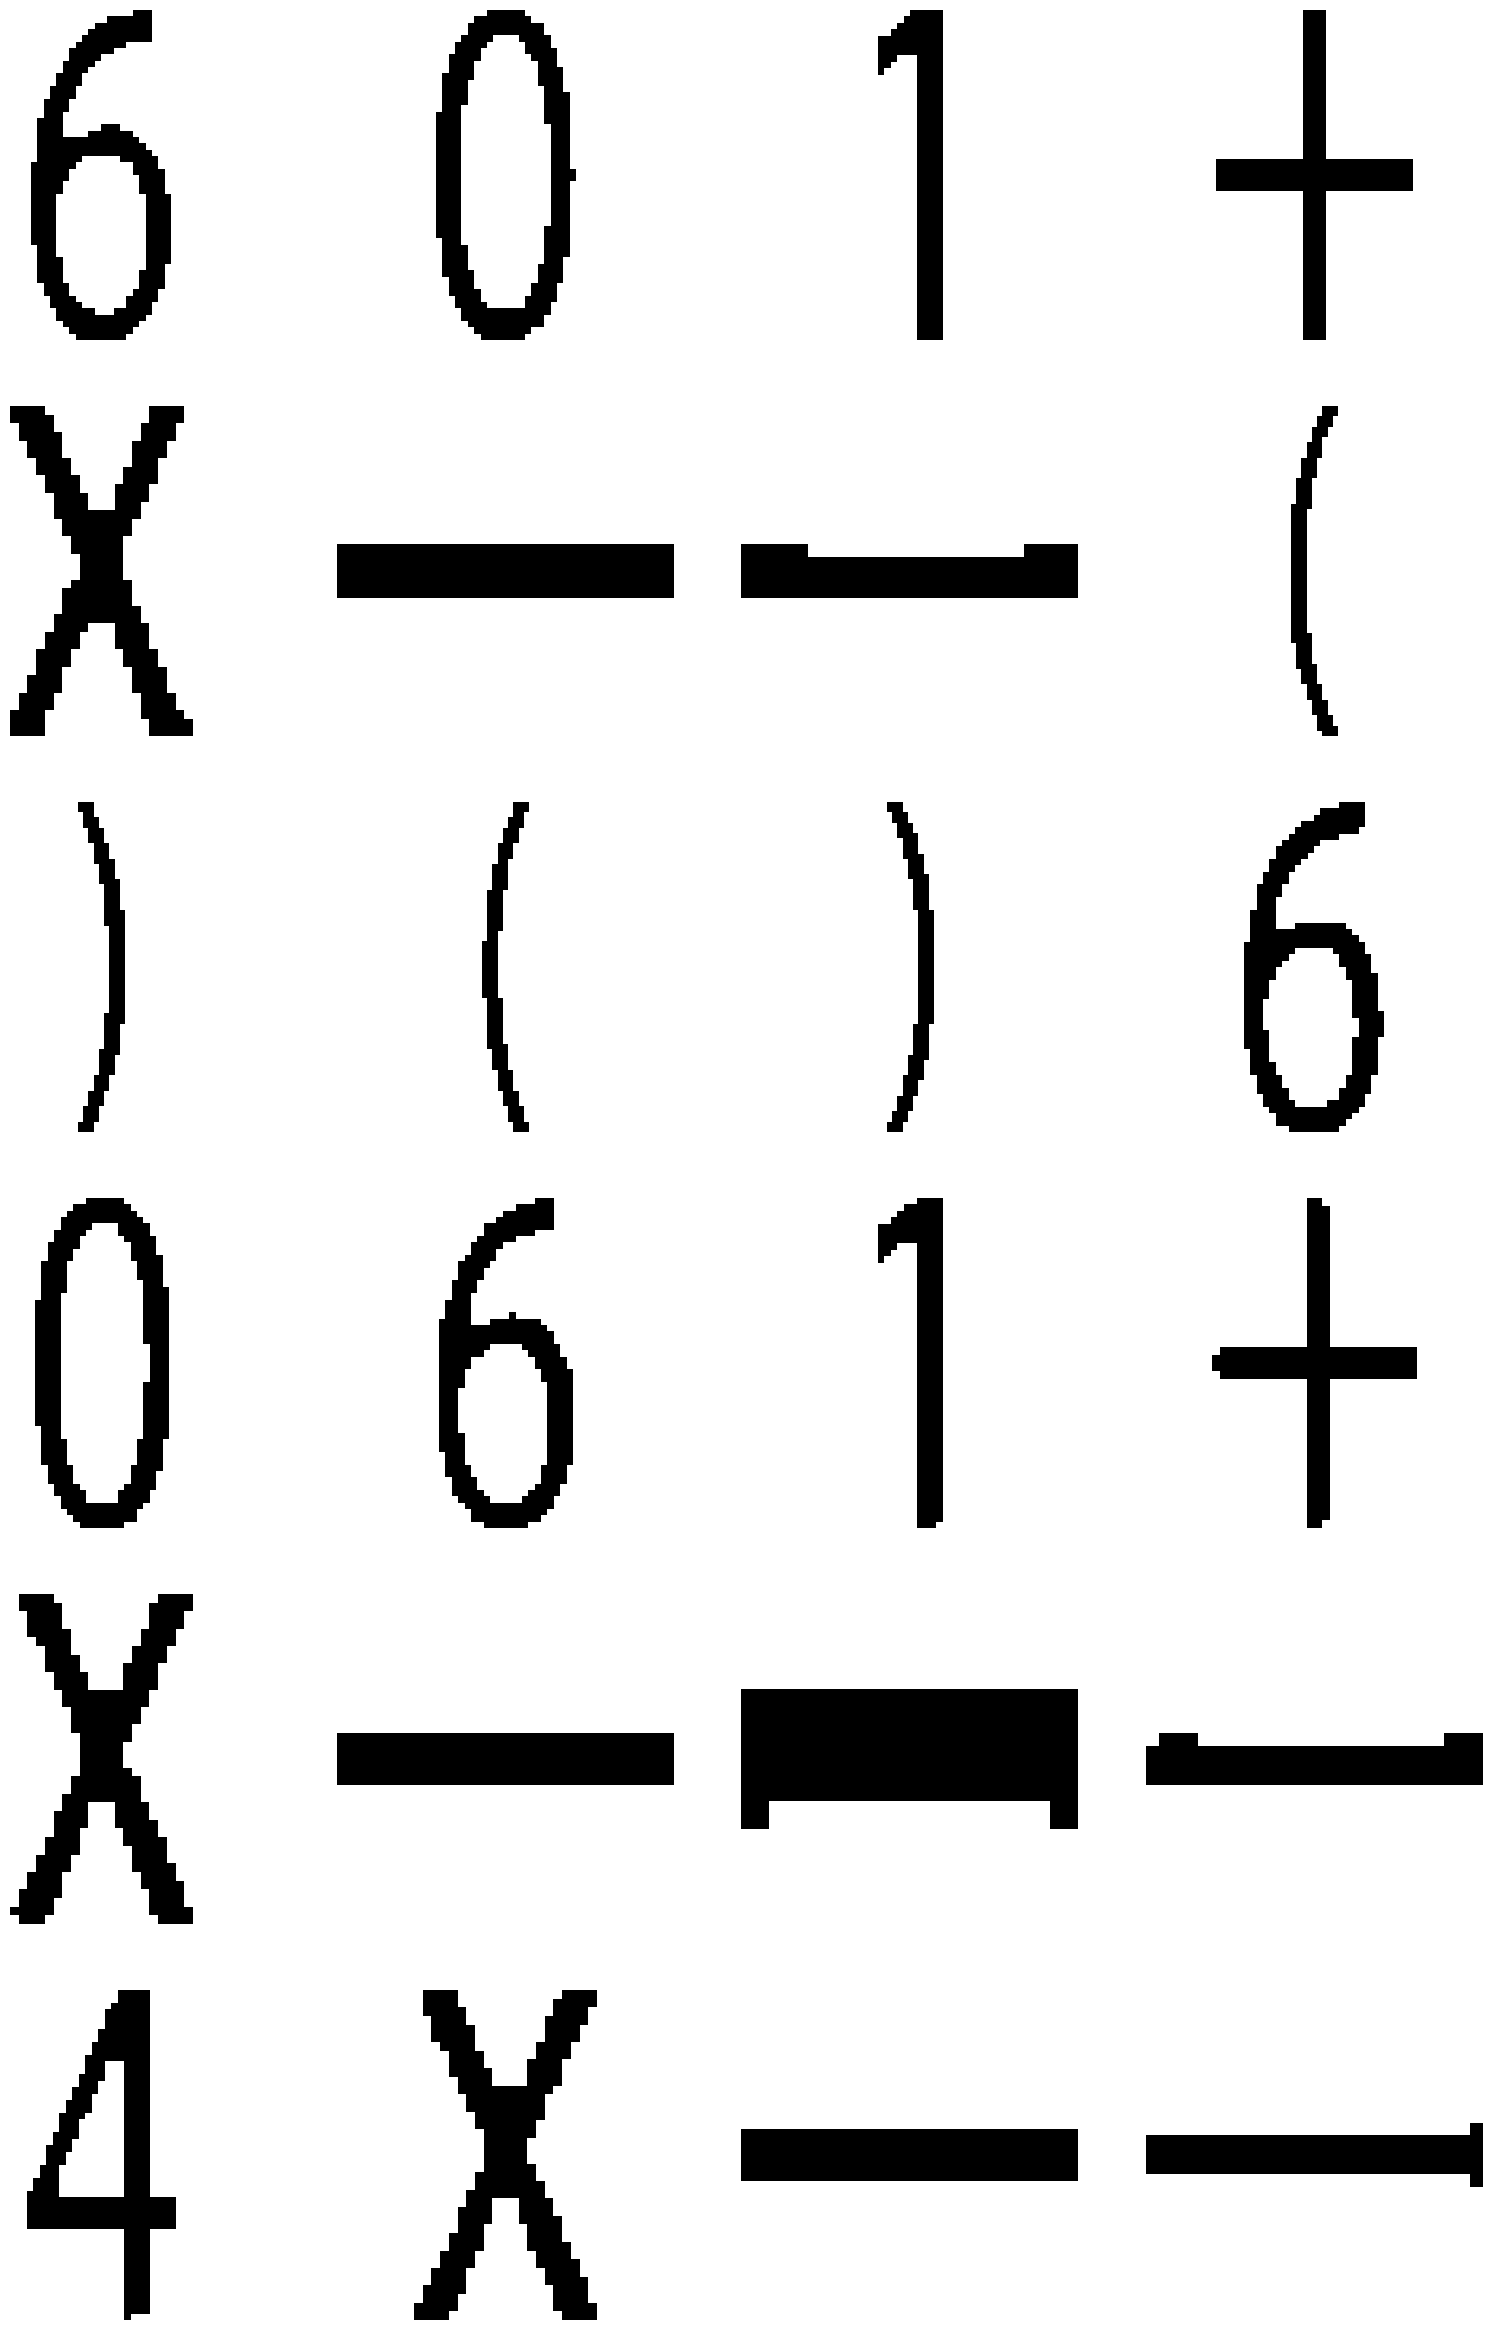

In [11]:
# _, img_thresh = cv2.threshold(img_thresh, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((3, 3), np.uint8)
img_thresh = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, kernel)

# Find contours of the text regions
contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours = sorted(contours, key=lambda ctr: (cv2.boundingRect(ctr)[1], cv2.boundingRect(ctr)[0]))

# Extract rows of text
img_thresh = 255 - img_thresh
rows = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    row = img_thresh[y:y+h, x:x+w]
    rows.append(row)

# Determine the number of rows and columns for subplots
num_rows = int(np.ceil(len(rows) / 4))  # Assuming 4 images per row
num_cols = min(len(rows), 4)

# Display the rows
plt.figure(figsize=(num_cols * 5, num_rows * 5))
for i, row in enumerate(rows):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(cv2.cvtColor(row, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.show()


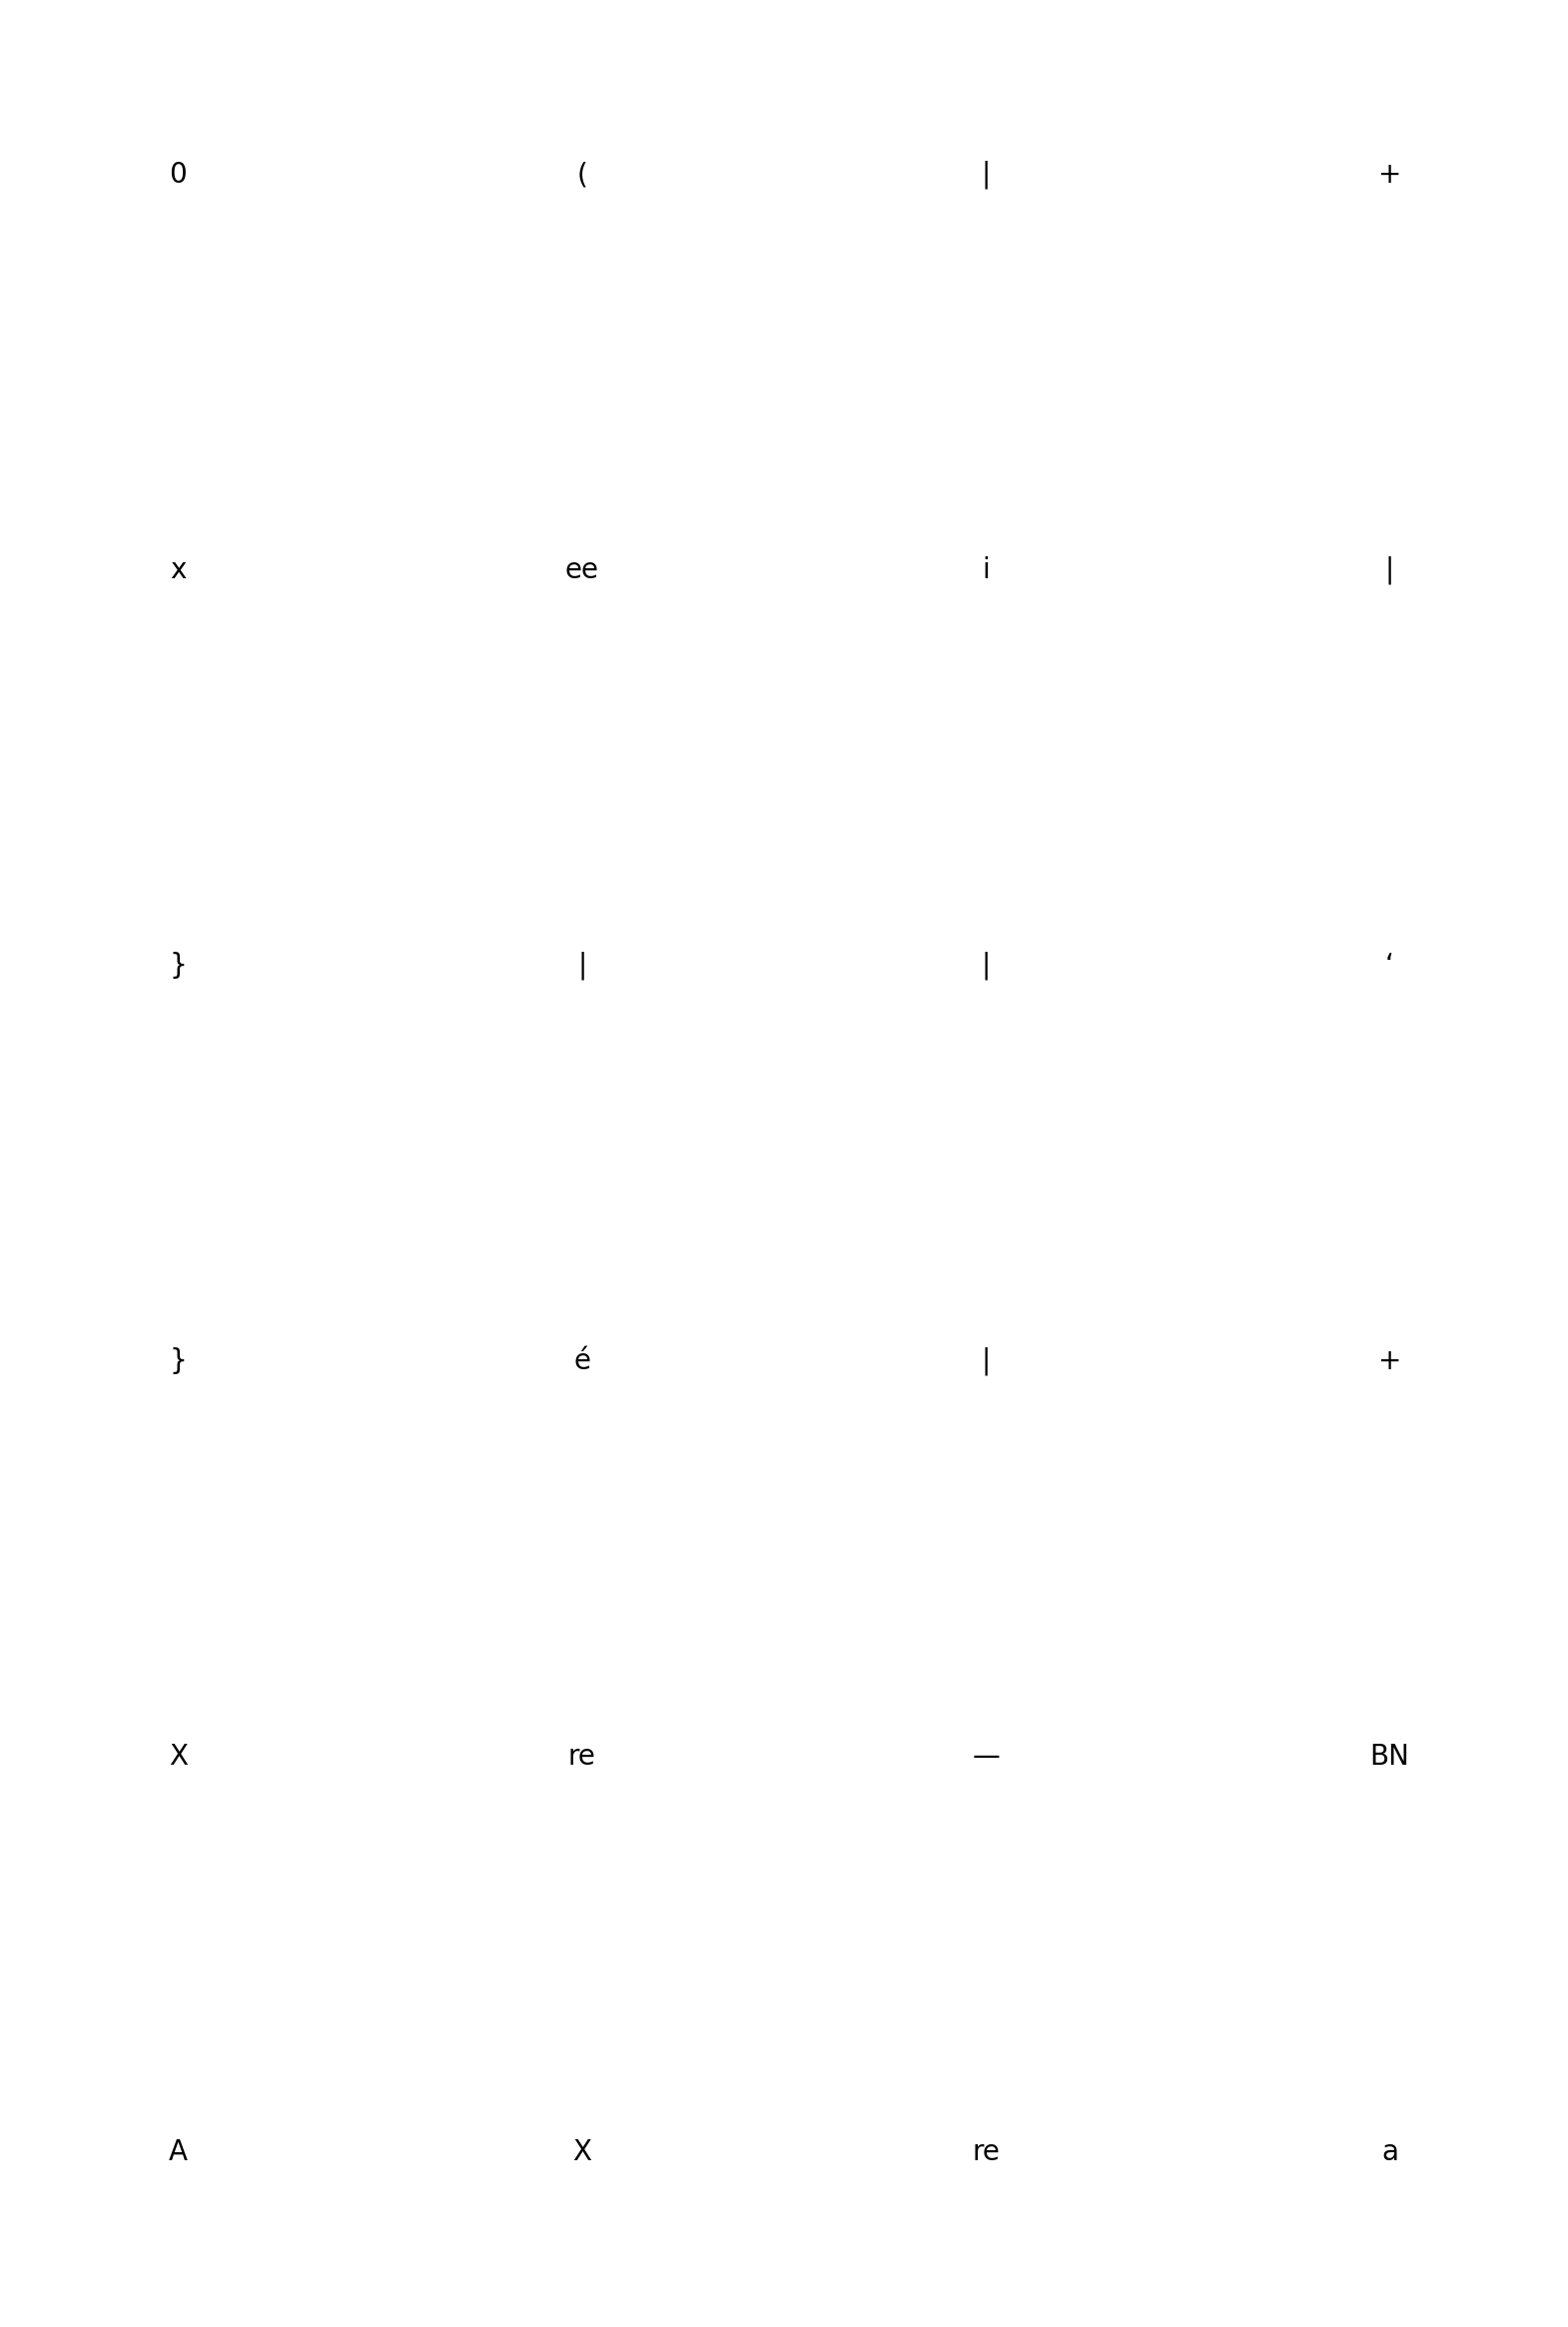

In [12]:
from PIL import Image

# Recognize symbols using Pytesseract OCR
recognized_symbols = []
for symbol_region in rows:
    # Convert symbol region to PIL Image format
    symbol_image = Image.fromarray(cv2.cvtColor(symbol_region, cv2.COLOR_BGR2RGB))

    # Perform OCR on the symbol region
    symbol_text = pytesseract.image_to_string(symbol_image, config='--psm 10')  # Page segmentation mode 10 for single character
    recognized_symbols.append(symbol_text.strip())

# Determine the number of rows and columns for subplots
num_rows = int(np.ceil(len(recognized_symbols) / 4))  # Assuming 4 symbols per row
num_cols = min(len(recognized_symbols), 4)

# Display the recognized symbols
plt.figure(figsize=(num_cols * 5, num_rows * 5))
for i, symbol_text in enumerate(recognized_symbols):
    plt.subplot(num_rows, num_cols, i+1)
    plt.text(0.5, 0.5, symbol_text, fontsize=20, ha='center', va='center')
    plt.axis('off')

plt.show()


In [33]:
from PIL import Image
from pix2tex.cli import LatexOCR
from IPython.display import display, Latex

img = Image.open('simple-eq.jpg')
model = LatexOCR()
latex_output = model(img)
print(latex_output)

display(Latex('$' + latex_output + '$'))

\left.\mathrm{\bf{M}~}\left[\begin{array}{c}{{\dot{V}(1,t)}}\\ {{\dot{V}(2,t)}}\\ {{\dot{\bf{\ell}}}}\\ {{\bf{\hat{\ell}}(n,t)}}\\ {{\bf{\hat{\ell}}}}\\ {{\bf{\hat{\ell}}}}\\ {{\bf{\hat{\ell}}}}\\ {{\bf{\hat{\ell}}}}\\ {{\bf{\hat{\ell}}(n,t)}}\end{array}\right]_{\begin{array}{c}{{\hat{\bf{\hat{\ell}}}}}\\ {{\bf{\hat{\ell}}(n,t)}}\end{array}\right)+\mathrm{\bf{K}}\left[\begin{array}{c}{{V(1,t)}}\\ {{\bf{\hat{\ell}}(n,t)}}\\ {{\bf{\hat{\ell}}}}\end{array}\right]_{\bf{\hat{\hat{\ell}}}}=\mathrm{\bf{P}}\ ,


<IPython.core.display.Latex object>